In [1]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
import torch
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
from os.path import join as oj
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../experiments')
from auggam import config
pd.set_option('display.max_rows', None)

# extract the relevant model

In [2]:
cached_model = oj(config.repo_dir, 'results', 'sst_bert_finetuned_ngrams=2.pkl')
row = pkl.load(open(cached_model, "rb"))

# r = data.load_fitted_results(fname_filters=['bert-base', 'sub=-1'], dset_filters=['sst2'])
# row = r[(r.checkpoint == 'textattack/bert-base-uncased-SST-2') & (r.ngrams == 2)].iloc[0]

/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# find vocab of 1/2-grams
nlp = English()
simple_tokenizer = nlp.tokenizer # for our word-finding
simple_tokenizer = lambda x: [str(x) for x in nlp.tokenizer(x)] # for our word-finding

dataset = datasets.load_dataset('sst2')
vectorizer = CountVectorizer(tokenizer=simple_tokenizer, ngram_range=(1, row.ngrams))
vectorizer.fit(dataset['train']['sentence'])
vocab_counts = vectorizer.vocabulary_
seqs_all = sorted(vocab_counts.keys())

Found cached dataset sst2 (/home/chansingh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Get embeddings

In [7]:
tokenizer = AutoTokenizer.from_pretrained(row.checkpoint) # for actually passing things to the model
model = BertModel.from_pretrained(row.checkpoint)
logistic = row.model
seqs = np.array(seqs_all).tolist()

try:
    embs = pkl.load(open('../results/embs_sst_unigram_bigram.pkl', 'rb'))
except:    
    # n_plot = 300
    # seqs = np.array(seqs_all)[np.random.choice(len(seqs_all), size=n_plot, replace=False)].tolist()
    device = 'cpu'
    tokens = tokenizer(seqs, padding=True, truncation=True, return_tensors="pt").to(device)
    model = model.to(device)
    with torch.no_grad():
        output = model(**tokens) # has two keys, 'last_hidden_state', 'pooler_output'
    embs = output['pooler_output'].cpu().detach().numpy()
    pkl.dump(embs, open('../results/embs_sst_unigram_bigram.pkl', 'wb'))

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Plot top coefs

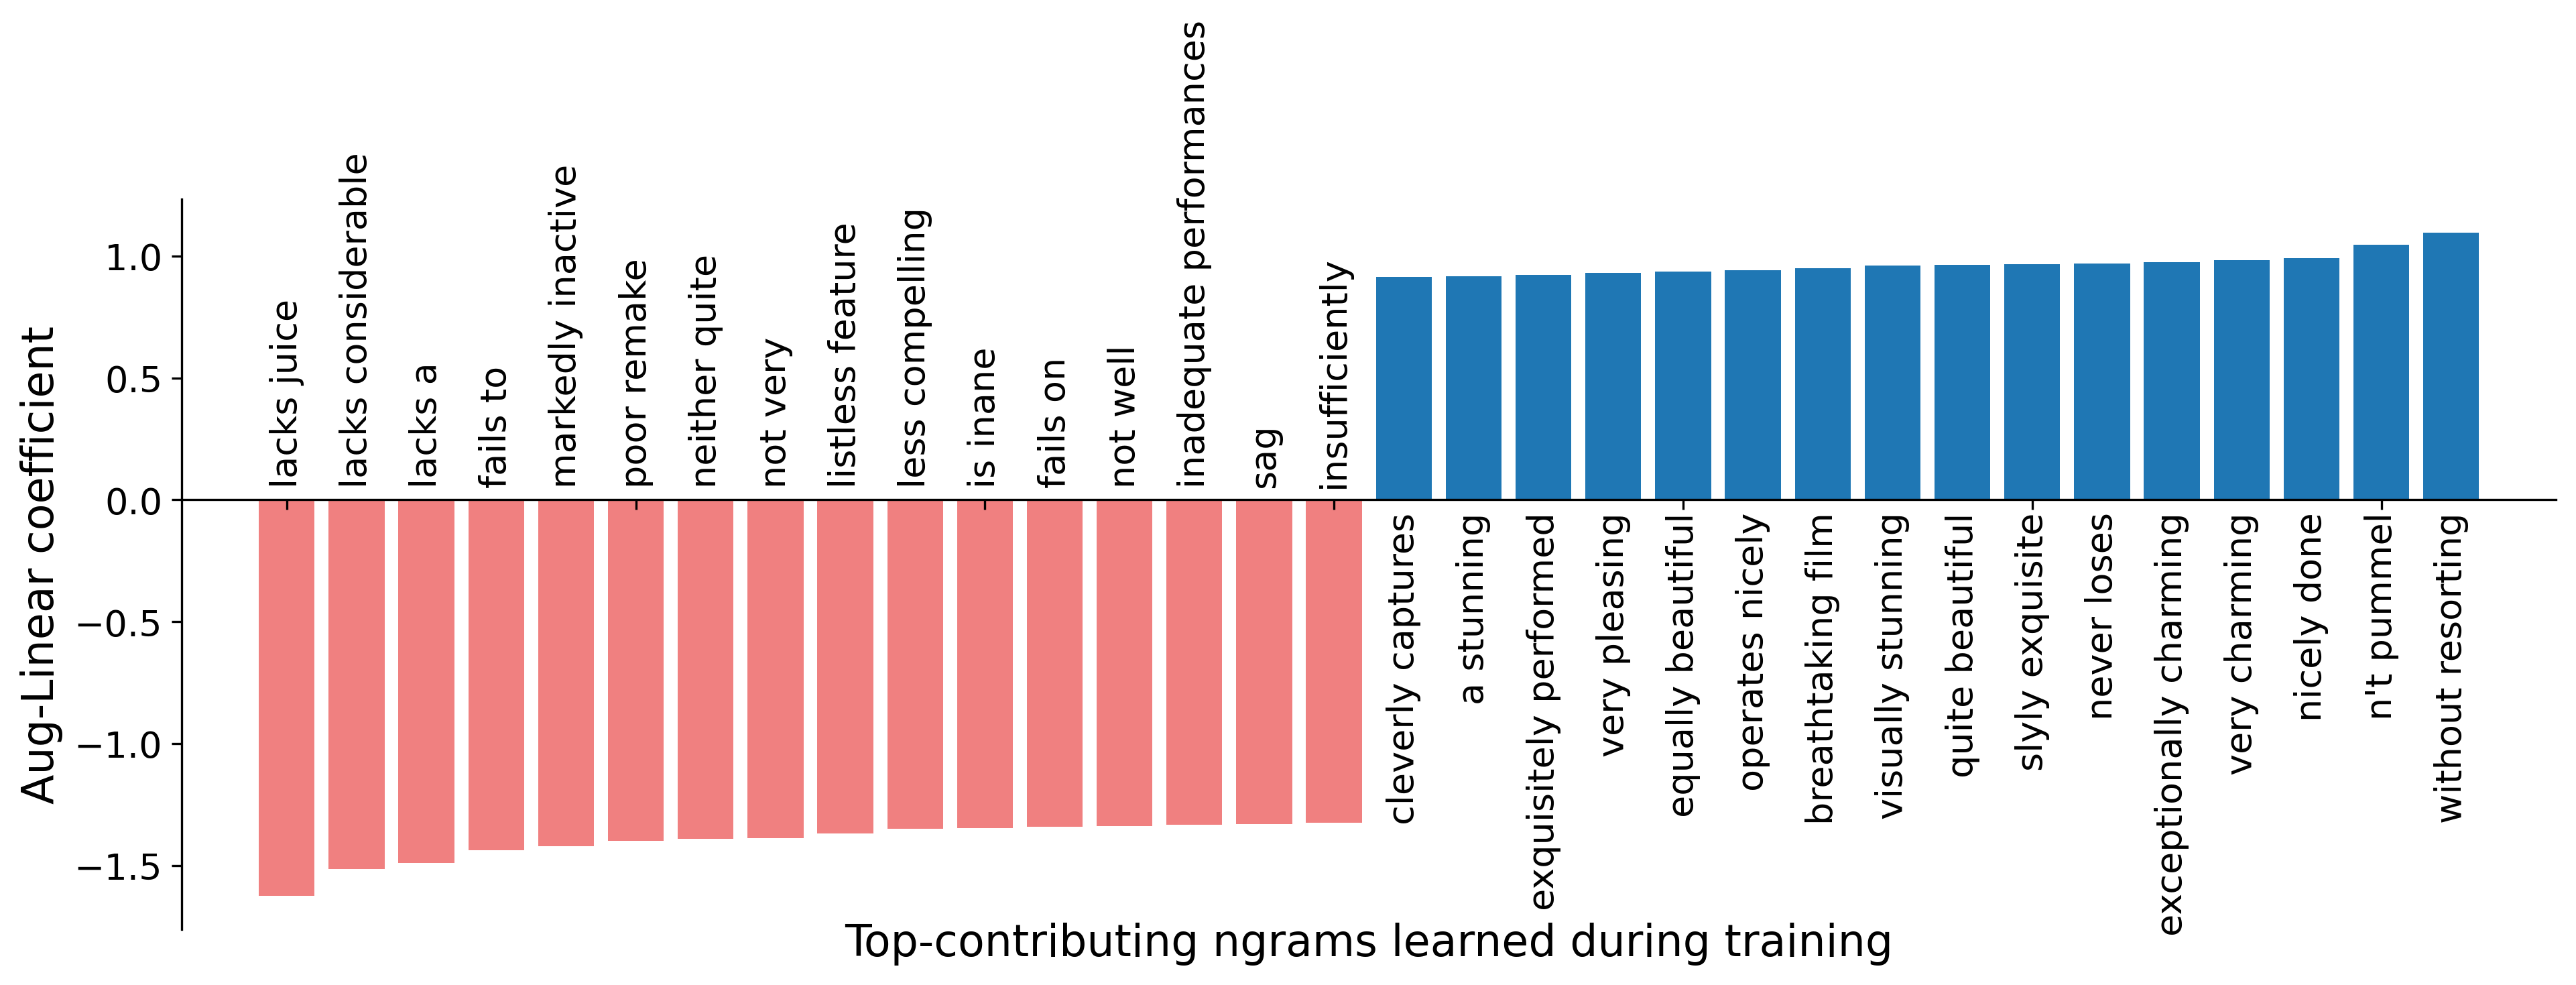

In [10]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(dpi=300, figsize=(13, 5))


# pick top
num_top = 16
logits = embs @ logistic.coef_.squeeze() # + logistic.intercept_
args = np.argsort(logits)
args = np.concatenate((args[::5][:num_top], args[::5][-num_top:]))

# make plot
x = np.arange(args.size)
y = logits[args]
labels = np.array(seqs)[args].astype(str).tolist()
p1 = ax.bar(x=x, height=y,
       color=['lightcoral'] * num_top + ['C0'] * num_top)
ax.set_xticklabels([])
# remove the extra tick on the negative bar
# ax.set_xticks([idx for (idx, x) in enumerate(performance) if x > 0])
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


label_offset = 0.05
for label, (x_position, y_position) in zip(labels, enumerate(y)):
    if y_position > 0:
        label_y = -label_offset
        ax.text(x_position, label_y, label, ha="center", va="top", rotation=90)
    else:
        label_y = +label_offset
        ax.text(x_position, label_y, label, ha="center", va="bottom", rotation=90)
# Placing the x-axis label, note the transformation into `Axes` co-ordinates
# previously data co-ordinates for the x ticklabels
ax.text(0.5, 0.01, "Top-contributing ngrams learned during training", ha="center", va="top", transform=ax.transAxes, fontsize='large')
plt.ylabel('Aug-Linear coefficient', fontsize='large')
plt.xlim([-1.5 , x.size + 0.5])
plt.tight_layout()
plt.savefig('ngram-contribution.pdf')
plt.show()